In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Adversarial perturbations:**
$$
\max_{\lVert\delta\rVert \leq \epsilon} \ell(h_\theta(x + \delta), y)
$$
Pertubation $\delta$ within norm bound $\epsilon$ that maximizes loss of nnet $h_\theta$. Simply, backprop on $\delta$ with gradients $\alpha \nabla_\delta\ell$ clipped by $[-\epsilon, \epsilon]$. The **fast gradient sign method** simply follows the observation that the largest step size we would take in the $\ell_\infty$-ball is $\epsilon \cdot \text{sign}(\nabla_\delta\ell)$. 

In [ ]:
def fgsm(model, x, y, criterion, eps):
    """
    https://adversarial-ml-tutorial.org/adversarial_examples/
    """
    delta = torch.zeros_like(x, requires_grad=True) # noise with gradients
    loss = criterion(model(x + delta), y) # loss wrt perturbed input
    loss.backward() # backprop on delta
    return eps * delta.grad.detach().sign() # FGSM pertubation

**Projected Gradient Descent:**
We can iteratively project onto $\ell_p$-balls to generalize outside of $\ell_\infty$ (which corresponds to if the small region was linear, which it is not in nnets).
$$
\delta := \mathcal{P}_{\ell_p}(\delta  + \alpha \nabla_\delta \ell(h_\theta(x + \delta), y)
$$

Then we apply normalized gradient descent for alleviating relative gradient scaling issues to give
$$
\arg\max_{\lVert v\rVert_\infty \leq \alpha} v^\top \nabla_z f(z) = \alpha\cdot \text{sign}(\nabla_zf(z)) \qquad \text{we can get closed forms in other norms too}
$$
and 
$$
z := z - \arg\max_{\lVert v\rVert \leq \alpha} v^\top \nabla_z f(z)
$$
We can choose the norm to match the norm that we are maximizing our pertubation to.

Essentially, we pick the optimal gradient *direction* to optimize pertubations by.

Hyperparameters:
- Since the step size α is on the same scale as the total perturbation bound ϵ, it makes sense to choose α to be some reasonably small fraction of ϵ, and then choose the number of iterations to be a small multiple of ϵ/α. (https://adversarial-ml-tutorial.org/adversarial_examples/)

Projecting on the $\ell_2$-ball will have a simple closed form and result in more localized attacks (whereas the $\ell_\infty$-ball results in more globally noisy attacks).

In [ ]:
def pgd_linf(model, x, y, criterion, eps, step_size, adv_steps, randomize = True):
    """ 
    PGD l-inf norm
    https://adversarial-ml-tutorial.org/adversarial_examples/
    """
    if randomize: 
        delta = torch.rand_like(x, requires_grad=True) # uniform random -> can start pertubations at different locations
        delta.data = delta.data * 2 * eps - eps
    else:
        delta = torch.zeros_like(x, requires_grad=True) # start w/ no noise
        
    for t in range(adv_steps):
        z = model(x + delta)
        #print(z.shape)
        loss = criterion(z, y) # perturbed loss
        loss.backward() # gradiets wrt delta 
        delta.data = (delta + step_size*delta.grad.detach().sign()).clamp(-eps,eps) # linf clamp
        delta.grad.zero_() # reset grads
    return delta.detach() # optimal perturbation projected onto linf ball


For adversarial training, we want to minimize loss such that 
$$
\theta^* := \arg\min_\theta \frac{1}{|S|}\sum_{x, y \in S} \max_{\lVert \delta \rVert \leq \epsilon} \ell(h_\theta(x + \delta), y)
$$
where we might apply PGD as a starting point to solve the inner maximization, and just apply nnet black-box optimization on the overall minimization.

In [ ]:
# https://github.com/HobbitLong/SupContrast/blob/master/losses.py
"""
Author: Yonglong Tian (yonglong@mit.edu)
Date: May 07, 2020
"""
from __future__ import print_function

import torch
import torch.nn as nn


class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR
    
    -- Ryan
    Modifications made as per https://github.com/HobbitLong/SupContrast/issues/104
    """
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        # normalize
        features = torch.nn.functional.normalize(features, p=2, dim=2)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one': # compare to one anchor
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all': # compare all
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-6)

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask*log_prob).sum(1)/(mask.sum(1)+1e-6)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [ ]:
# AE module
class Encoder(nn.Module):
    def __init__(self, x_dim, z_dim, fc_dims):
        super(Encoder, self).__init__()
        self.fc_dims = fc_dims

        # encoder modules 
        if not self.fc_dims: # no hidden layers
            self.encoder = nn.Linear(x_dim, z_dim)
        else: # arbitrary layers
            encoder = [nn.Linear(x_dim, self.fc_dims[0])]
            for i in range(1, len(self.fc_dims)):
                encoder.append(nn.Linear(self.fc_dims[i-1], self.fc_dims[i]))
            encoder.append(nn.Linear(self.fc_dims[-1], z_dim))
            self.encoder = nn.ModuleList(encoder)

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, x_dim, z_dim, fc_dims):
        super(Decoder, self).__init__()

        # reverse encoder fc's
        self.fc_dims = [fc_dims[i] for i in range(len(fc_dims) - 1, -1)]

        # decoder modules 
        if not self.fc_dims: # no hidden layers
            self.decoder = nn.Linear(z_dim, x_dim)
        else: # arbitrary layers
            decoder = [nn.Linear(z_dim, self.fc_dims[0])]
            for i in range(1, len(self.fc_dims)):
                decoder.append(nn.Linear(self.fc_dims[i-1], self.fc_dims[i]))
            decoder.append(nn.Linear(self.fc_dims[-1], x_dim))
            self.decoder = nn.ModuleList(decoder)

    def forward(self, z):
        return self.decoder(z)

class Autoencoder(nn.Module):
    def __init__(self, **kwargs):
        super(self, Autoencoder).__init__()
        self.encoder = Encoder(**kwargs)
        self.decoder = Decoder(**kwargs)

    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        xhat = self.decode(z)
        return z, xhat

In [ ]:
class ResNet(nn.Module):
    """
    resnet feature extractor
    """
    def __init__(self, num_channels, num_classes):
        super(ResNet, self).__init__()
        self.resnet = resnet50(weights = None)#'IMAGENET1K_V2') # finetuning
        self.resnet.conv1 = nn.Conv2d(num_channels, 64, 7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Linear(2048, num_classes) 
        self.feature_extractor = torch.nn.Sequential(*list(self.resnet.children())[:-1])

    def forward(self, x):
        z = self.feature_extractor(x)
        return z.view(z.shape[0], -1).unsqueeze(1)

    # def forward(self, x):
    #     return self.resnet(x)

In [ ]:

def epoch_standard(model, criterion, loader, epoch, optimizer = None, device = 'cpu'):
    """
    standard epoch
    """
    if optimizer:
        model.train()
        mode = 'Train'
    else:
        model.eval()
        mode = 'Val'

    train_loss = []
    batches = tqdm(enumerate(loader), total=len(loader))
    batches.set_description("Epoch NA: Loss (NA)")

    for batch_idx, (x, y) in batches:
        x, y = x.to(device), y.to(device)
        # outer minimization
        z = model(x)
        #print(z.shape)
        loss = criterion(z, y)
        #print(loss.item())
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss.append(loss.item())
        batches.set_description(
            "Epoch {:d}: {:s} Loss ({:.2e})".format(
                epoch, mode, loss.item()
            )
        )

    return np.mean(train_loss)

def epoch_adversarial(model, criterion, loader, epoch, eps=0.2, step_size=1e-2, adv_steps=40, optimizer = None, device = 'cpu'):
    """
    eps -- l_inf bound
    step_size -- delta stepsize for inner maximization
    adv_steps -- number of steps of adversarial pertubation
    """
    if optimizer:
        model.train()
        mode = 'Train'
    else:
        model.eval()
        mode = 'Val'

    train_loss = []
    batches = tqdm(enumerate(loader), total=len(loader))
    batches.set_description("Epoch NA: Adversarial Loss (NA)")

    for batch_idx, (x, y) in batches:
        x, y = x.to(device), y.to(device)
        # inner maximization
        delta = pgd_linf(model, x, y, criterion, eps, step_size, adv_steps)

        # outer minimization
        z = model(x + delta)
        loss = criterion(z, y)
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss.append(loss.item())
        batches.set_description(
            "Epoch {:d}: {:s} Adversarial Loss ({:.2e})".format(
                epoch,mode, loss.item()
            )
        )
    return np.mean(train_loss)

In [ ]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,], std=[0.5, ])
])


train_fm = FashionMNIST(root='.', download=True, train = True, 
                        transform = transform)
train_size = int(0.85 * len(train_fm))
val_size = len(train_fm) - train_size

train_fm, val_fm = torch.utils.data.random_split(train_fm, [train_size, val_size])
test_fm = FashionMNIST(root='.', download=True, train = False)

print(len(train_fm), len(val_fm), len(test_fm))

100%|██████████| 26421880/26421880 [00:02<00:00, 13169069.85it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 91699913.01it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2661875.94it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5547861.51it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw

51000 9000 10000


In [ ]:
batch_size = 128
train_loader = DataLoader(train_fm, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_fm, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_fm, batch_size = batch_size, shuffle = False)

In [ ]:
# for image, label in train_loader:
#     net = ResNet(1, 10)
#     print(net(image).shape)
#     print(net.extract_features(image).shape)
#     break

In [ ]:
NUM_EPOCHS = 5
LR = 3e-4
VAL_TYPE = 'standard' # or 'adversarial'

###### Supervised Contrastive Loss ######
temp = 0.07
criterion = SupConLoss(temperature = temp, 
                       contrast_mode = 'all', 
                       base_temperature = 0.07)

# might need to redefine resnet as its own class
# supcon takes in features, so would need to input 2nd last layer features
num_classes = len(torch.unique(train_fm.dataset.targets))
net = ResNet(1, num_classes).to(device)

optimizer = torch.optim.AdamW(net.parameters(), lr = LR)


###### Train Model ######
train_losses = {'standard':[], 'adversarial':[]}
val_losses = {'standard':[], 'adversarial':[]}
best_val = float("inf")
best_epoch = 0

for epoch in tqdm(range(NUM_EPOCHS)):

    # train 
    train_loss = epoch_standard(net, criterion, train_loader, epoch, optimizer, device = device)
    train_loss_adv = epoch_adversarial(net, criterion, train_loader, epoch, eps=0.2, step_size=1e-2, adv_steps=10, optimizer = optimizer, device = device)
    train_losses['standard'].append(train_loss)
    train_losses['adversarial'].append(train_loss_adv)

    # eval 
    val_loss = epoch_standard(net, criterion, val_loader, epoch, optimizer = None, device = device)
    val_loss_adv = epoch_adversarial(net, criterion, val_loader, epoch, eps=0.2, step_size=1e-2, adv_steps=10, optimizer = None, device = device)
    val_losses['standard'].append(val_loss)
    val_losses['adversarial'].append(val_loss_adv)

    # retain best val
    if best_val > val_losses[VAL_TYPE][-1]:
        best_val = val_losses[VAL_TYPE][-1]
        best_epoch = epoch
        # save model parameter/state dictionary

# load best weights
print(f"Best epoch at {best_epoch} with {VAL_TYPE} loss: {best_val}")



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Best epoch at 0 with standard loss: -inf


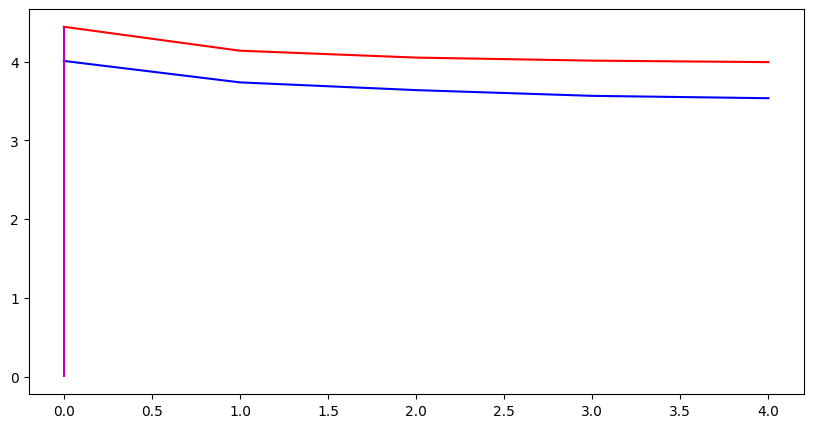

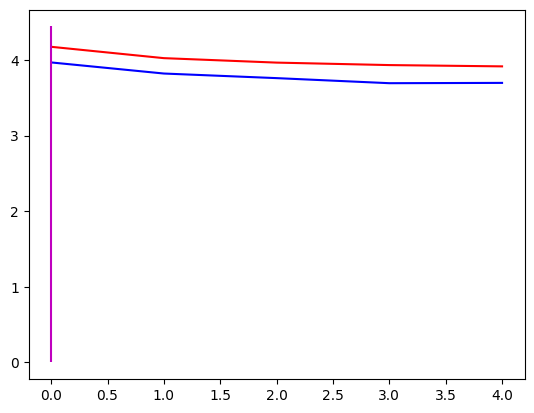

In [ ]:
# plot losses
plt.figure(figsize = (10, 5))
ymax = max(max(train_losses['standard']), max(train_losses['adversarial']))

plt.plot(range(NUM_EPOCHS), train_losses['standard'], c = 'b')
plt.plot(range(NUM_EPOCHS), train_losses['adversarial'], c = 'r')
plt.vlines(best_epoch, ymin = 0, ymax = ymax, colors = 'm')
plt.show()

plt.plot(range(NUM_EPOCHS), val_losses['standard'], c = 'b')
plt.plot(range(NUM_EPOCHS), val_losses['adversarial'], c = 'r')
plt.vlines(best_epoch, ymin = 0, ymax = ymax, colors = 'm')
plt.show()

Visualizing loss surface and gradient direction...

Visualizing adversarially trained gradient direction